## Noise2Noise U-Net

In this notebook, we will implement "Noise2Noise: Learning Image Restoration without Clean Data".

## Required dependencies

In [266]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio

from pathlib import Path

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Data loading and preprocessing
For this excercise will use the [VDSR dataset](https://cv.snu.ac.kr/research/VDSR) containing 'clean' (no noise added) natural images.

Let's start with downloading and unzipping the data.

In [5]:
!wget https://cv.snu.ac.kr/research/VDSR/train_data.zip
!wget https://cv.snu.ac.kr/research/VDSR/test_data.zip
!mkdir -p vdsr_train
!mkdir -p vdsr_test
!unzip -qq train_data.zip -d vdsr_train && rm train_data.zip
!unzip -qq test_data.zip -d vdsr_test && rm test_data.zip

unzip:  cannot find or open train_data.zip, train_data.zip.zip or train_data.zip.ZIP.
unzip:  cannot find or open test_data.zip, test_data.zip.zip or test_data.zip.ZIP.


Same as in previous excerices we're going to create our custom `Dataset` class for loading all the images from disk.

In [156]:
class VdsrDataset(Dataset):
    def __init__(self, root_dir, noise_transform, crop_size=256):
        image_suffixes = (".jpeg", ".jpg", ".png", ".bmp")
        self.image_paths = [p for p in Path(root_dir).glob("**/*") if p.suffix.lower() in image_suffixes]
        assert noise_transform is not None
        # transforms the image according to the noise model
        self.noise_transform = noise_transform
        #  standard transformations to apply to the input images
        self.inp_transforms = transforms.Compose([
            # randomly crop the image, paddig if necessary
            transforms.RandomCrop(crop_size, pad_if_needed=True, padding_mode='reflect'),
            # converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
            transforms.ToTensor()
        ])
        
    # get the total number of samples
    def __len__(self):
        return len(self.image_paths)

    # fetch the training sample given its index
    def __getitem__(self, idx):
        # read image from disk
        img = imageio.imread(self.image_paths[idx])
        # convet to PIL image
        img = Image.fromarray(img)
        # apply standard augmentations
        img = self.inp_transforms(img)
        # apply the noise model and return a source and target image
        return self.noise_transform(img)

Let's create the training dataset and show some of the images

In [157]:
TRAIN_DATA_PATH = 'vdsr_train'
# dummy transform, which just returns the input image twice
t = lambda x: (x, x)
train_data = VdsrDataset(TRAIN_DATA_PATH, noise_transform=t)

In [230]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img1, img2 = dataset[idx]                    # get the image and the nuclei masks
    # convert (C,H,W) to (H,W,C)
    img1 = np.transpose(img1, (1, 2, 0)) 
    img2 = np.transpose(img2, (1, 2, 0)) 
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img1)                     # show the image
    axarr[1].imshow(img2)                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print(f'Image size is {img1.shape}')
    plt.show()

Image size is torch.Size([256, 256, 3])


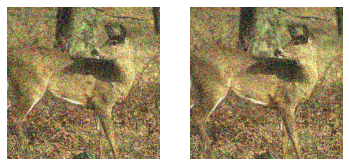

In [231]:
show_random_dataset_image(train_data)

Finally let's create our noise model. We will study the effect of corrupted targets using
synthetic additive Gaussian noise.

In [171]:
class AugmentGaussian:
    def __init__(self, train_stddev_rng_range):
        assert len(train_stddev_rng_range) == 2
        self.train_stddev_range = train_stddev_rng_range

    def __call__(self, x):
        (minval, maxval) = self.train_stddev_range
        rng_stddev = (maxval - minval) * torch.rand(1) + minval
        x = x + torch.randn(x.size()) * rng_stddev
        return torch.clamp(x, min=0, max=1)

Let's create our noise augmentor, which randomize the noise standard deviation for source and target image separately. We choose σ ∈ [0, 0.2] and then create the train loader.

In [289]:
additive_gaussian_noise_train = AugmentGaussian((0, 0.25))
TRAIN_NOISE_TRANSFORM = lambda x: (additive_gaussian_noise_train(x), additive_gaussian_noise_train(x))

TRAIN_DATA_PATH = 'vdsr_train'
train_data = VdsrDataset(TRAIN_DATA_PATH, noise_transform=TRAIN_NOISE_TRANSFORM)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

Image size is torch.Size([256, 256, 3])


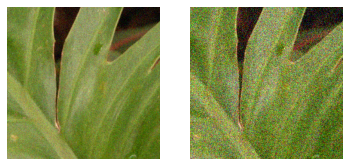

In [290]:
show_random_dataset_image(train_data)

Create validation loader. This time we use a fixed standard deviation of 0.1 for the additive Gaussian noise.

In [291]:
additive_gaussian_noise_val = AugmentGaussian((0.1, 0.1))
VAL_NOISE_TRANSFORM = lambda x: (additive_gaussian_noise_val(x), additive_gaussian_noise_val(x))

VAL_DATA_PATH = 'vdsr_test'
val_data = VdsrDataset(VAL_DATA_PATH, noise_transform=VAL_NOISE_TRANSFORM)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)

Image size is torch.Size([256, 256, 3])


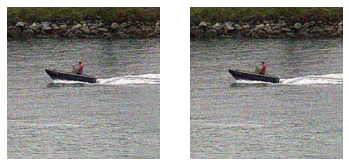

In [293]:
show_random_dataset_image(val_data)

## U-net architecure 

We're going to use the same architectue as described in Appendix 1 of  J. Lehtinen, J. Munkberg, J. Hasselgren, S. Laine, T. Karras, M. Aittala, T. Aila, "Noise2Noise: Learning Image Restoration without Clean Data"

In [207]:
class UNet(nn.Module):
    """ UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
    """
    
    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with leaky ReLU activation
    def _conv_block(self, in_channels, out_channels, block_num):
        conv_blocks = []
        for i in range(block_num):
            if i == 0:
                in_ch = in_channels
            else:
                in_ch = out_channels
            # add convolutional layer
            conv_blocks.append(nn.Conv2d(in_ch, out_channels, kernel_size=3, padding=1))
            # add activation function
            conv_blocks.append(nn.LeakyReLU(negative_slope=0.1, inplace=True))
            
        return nn.Sequential(*conv_blocks)       


    # upsampling via nearest-neighbor interpolation
    def _upsample(self, x, size):
        return F.interpolate(x, size=size, mode='nearest')
    
    # we do use a final Sigmoid activation this time, since we're dealing with a regression problem
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        
        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 5
        self.depth = 5
        
        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList
        
        # modules of the encoder path
        self.encoder = nn.ModuleList([self._conv_block(in_channels, 48, 2),
                                      self._conv_block(48, 48, 1),
                                      self._conv_block(48, 48, 1),
                                      self._conv_block(48, 48, 1),
                                      self._conv_block(48, 48, 1)])
        # the base convolution block
        self.base = self._conv_block(48, 48, 1)
        # modules of the decoder path
        self.decoder = nn.ModuleList([self._conv_block(96, 96, 2),
                                      self._conv_block(144, 96, 2),
                                      self._conv_block(144, 96, 2),
                                      self._conv_block(144, 96, 2),
                                      self._conv_block(144, 64, 2)])
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        
        # output conv with linear activation
        self.out_conv = nn.Conv2d(64, out_channels, 1)
    
    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)
        
        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            # get the spatial dimension of the corresponding encoder features
            size = encoder_out[level].size()[2:]
            x = self._upsample(x, size)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
        
        # apply output conv
        x = self.out_conv(x)
        return x

Having the network architecture implemented, let's make a single forward pass with a random image in order to see that it's working

In [275]:
m = UNet(in_channels=3, out_channels=3)

idx = np.random.randint(0, len(train_data))
img = train_data[idx][0]
img = img.unsqueeze(0)

output = m(img)

## Loss and evaluation metrics

Since we're using the additive Gaussian noise, which has a zero mean, we will use an `L_2` (`MSE`) loss.

[Peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noi) will be used as our evaluation metric.

In [283]:
LOSS_CRITERION = nn.MSELoss()

class PSNR:
    def __call__(self, image_true, image_test):
        image_true = image_true.detach().numpy()
        image_test = image_test.detach().numpy()
        image_test = np.clip(image_test, 0., 1.)
        return peak_signal_noise_ratio(image_true, image_test)
    
EVAL_METRIC = PSNR()

## Training